In [1]:
import cv2
import torch
import numpy as np
from model.make_model import make_model
from config import cfg
from utils.metrics import Postprocessor

In [2]:
cfg.merge_from_file('TIL.yml')
REID = make_model(cfg, num_class=2, camera_num=1, view_num=1, semantic_weight=cfg.MODEL.SEMANTIC_WEIGHT)
REID.classifier = torch.nn.Identity()  # remove the classifier layer
REID.load_param('log_SGD_500epoch_continue_1e-4LR_expanded/transformer_21_map0.941492492396344_acc0.8535950183868408.pth')
REID.to('cuda')
REID.eval()

using Transformer_type: swin_base_patch4_window7_224 as a backbone


C:\Users\alien\Documents\PyCharm-Projects\TIL-2023\CV\SOLIDER-REID\model\backbones\swin_transformer.py:1153: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


===========building transformer===========
Loading pretrained model from log_SGD_500epoch_continue_1e-4LR_expanded/transformer_21_map0.941492492396344_acc0.8535950183868408.pth


build_transformer(
  (base): SwinTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (stages): ModuleList(
      (0): SwinBlockSequence(
        (blocks): ModuleList(
          (0-1): 2 x SwinBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftWindowMSA(
              (w_msa): WindowMSA(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop): DropPath()
            )
            (norm2): LayerNorm((128,), eps=1e-0

In [3]:
def load_img(img: np.ndarray):  # for REID only
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.transpose(img, (2, 0, 1))
    # normalize with mean and std supplied in cfg
    img = img / 255.0
    for channel in range(3):
        img[channel] -= cfg.INPUT.PIXEL_MEAN[channel]
        img[channel] /= cfg.INPUT.PIXEL_STD[channel]
    return img.astype(np.float32)

In [5]:
postprocessor = Postprocessor(num_query=2, max_rank=50, feat_norm=cfg.TEST.FEAT_NORM, reranking=True)
suspect = load_img(cv2.imread('../../Robot/data/imgs/suspect1.png'))
hostage = load_img(cv2.imread('../../Robot/data/imgs/targetmario.png'))
gallery = load_img(cv2.imread('../RT-DETR/dataset/reid/test_old/bounding_box_test/-1_c0s1_1_1.png'))
inputs = [suspect, hostage, gallery]
inputs = np.stack(inputs, axis=0)
features = REID(torch.from_numpy(inputs).to('cuda'))[0]
features = torch.cat((features, torch.ones(3417-1, features.shape[-1]).to('cuda')), dim=0)  # add fake gallery to make it same size as in train set
postprocessor.update(features.detach())  # postprocessor expects Torch tensor as it uses torch to compute stuff
dist_mat = postprocessor.compute()  # (2, 1) array, 2 queries, 1 gallery image
# dist_mat = np.squeeze(dist_mat)  # (2,)
# flatten the dist_mat
dist_mat = dist_mat.reshape(-1)
print(dist_mat)

C:\Users\alien\Documents\PyCharm-Projects\TIL-2023\CV\SOLIDER-REID\utils\reranking.py:40: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1485.)
  distmat.addmm_(1, -2, feat, feat.t())


[0.06452002 0.76630855 0.76630855 ... 0.7663086  0.7663086  0.7663086 ]


In [6]:
import os
import tqdm
postprocessor = Postprocessor(num_query=2, max_rank=50, feat_norm=cfg.TEST.FEAT_NORM, reranking=True)
dist = []
for file in tqdm.tqdm(os.listdir('../RT-DETR/dataset/reid/test_old/bounding_box_test/')):
    gallery = load_img(cv2.imread(os.path.join('../RT-DETR/dataset/reid/test_old/bounding_box_test/', file)))
    inputs = [suspect, hostage, gallery]
    inputs = np.stack(inputs, axis=0)
    features = REID(torch.from_numpy(inputs).to('cuda'))[0]
    features = torch.cat((features, torch.ones(3417-1, features.shape[-1]).to('cuda')), dim=0)  # add fake gallery to make it same size as in train set
    postprocessor.update(features.detach())  # postprocessor expects Torch tensor as it uses torch to compute stuff
    dist_mat = postprocessor.compute()  # (2, 1) array, 2 queries, 1 gallery image
    postprocessor.reset()
    # dist_mat = np.squeeze(dist_mat)  # (2,)
    # flatten the dist_mat
    dist_mat = dist_mat.reshape(-1)
    dist.extend(dist_mat.tolist())

  1%|          | 30/3417 [00:27<51:15,  1.10it/s] 


KeyboardInterrupt: 

In [7]:
import pickle
with open('eu_dist.pkl', 'wb') as f:
    pickle.dump(dist, f)

In [9]:
dist_flattened = []
for i in dist:
    if isinstance(i, float):
        dist_flattened.append(i)
    else:
        dist_flattened.extend(i)

In [10]:
dist_flattened = np.array(dist_flattened)

In [38]:
threshold = 0.29
dist_flattened_filtered = dist_flattened[dist_flattened < threshold]

In [16]:
import pickle
with open('rr_dist.pkl', 'rb') as f:
    dist = pickle.load(f)

(array([2.00000e+00, 2.50000e+01, 2.50000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 7.00000e+00, 2.04961e+05]),
 array([0.06452002, 0.13469888, 0.20487774, 0.2750566 , 0.34523546,
        0.41541431, 0.48559317, 0.55577203, 0.62595089, 0.69612975,
        0.76630861]),
 <BarContainer object of 10 artists>)

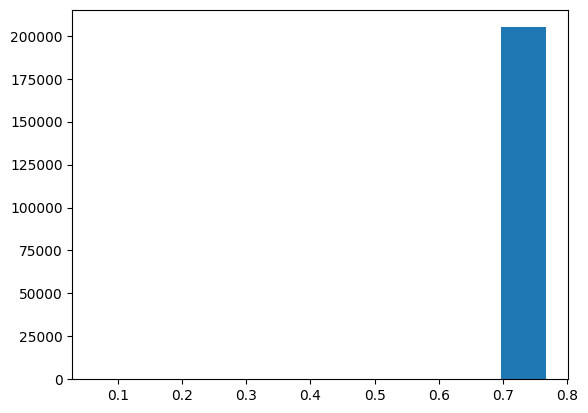

In [10]:
import matplotlib.pyplot as plt
plt.hist(dist, bins=100)